# Retrieval Augmented Generation with Elastic, Anthropic Claude 3, Amazon Bedrock and Langchain

## Introduction

In this notebook we will show you how to use Elastic search, Amazon Bedrock, Anthropic Claude 3 and Langchain to build a Retrieval Augmented Generation (RAG) solution


#### Use case

To demonstrate the RAG capability, let's take the use case of an AI Assistant that can help answer questions from a personal document. 


#### Persona
You are Bob,an Application Developer at Anycompany. Anycompany is experiencing an overwhelming number of customer queries. Anycompany has built a secure and performant conversational AI Assistant to answer frequently asked questions. Now Anycompany wants this conversational AI assistant to be able to answer questions are which are specific to the company. 

In this workshop, you will build a context aware conversational AI Assistant for Anycompany 

#### Implementation
To fulfill this use case, in this notebook we will show how to create a RAG Application to answer questions from business data. We will use  Elasticsearch, Anthropic Claude 3 Sonnet Foundation model, Amazon Bedrock and Langchain. 
We're using an Elastic Serverless deployment of Elasticsearch for this notebook. If you don't have an Elastic Cloud account, sign up [here](https://cloud.elastic.co/serverless-registration?onboarding_token=vectorsearch) for a free trial. Once you've signed up, you can create your Elasticsearch API Key following the documentation [here](https://www.elastic.co/docs/current/serverless/api-keys) or from your Elastic serverless homepage

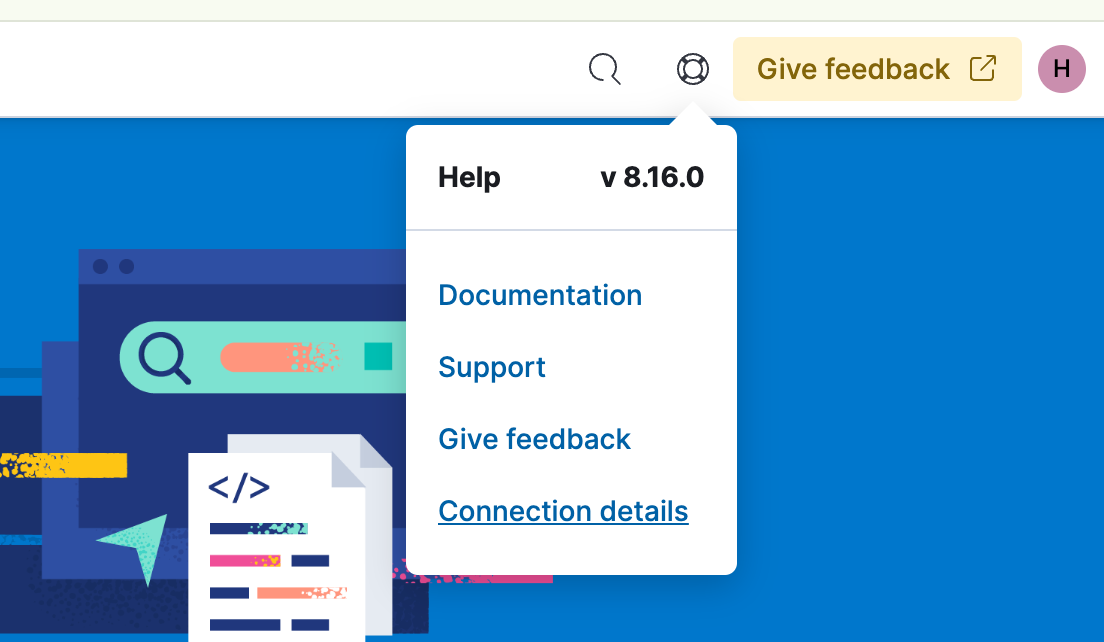

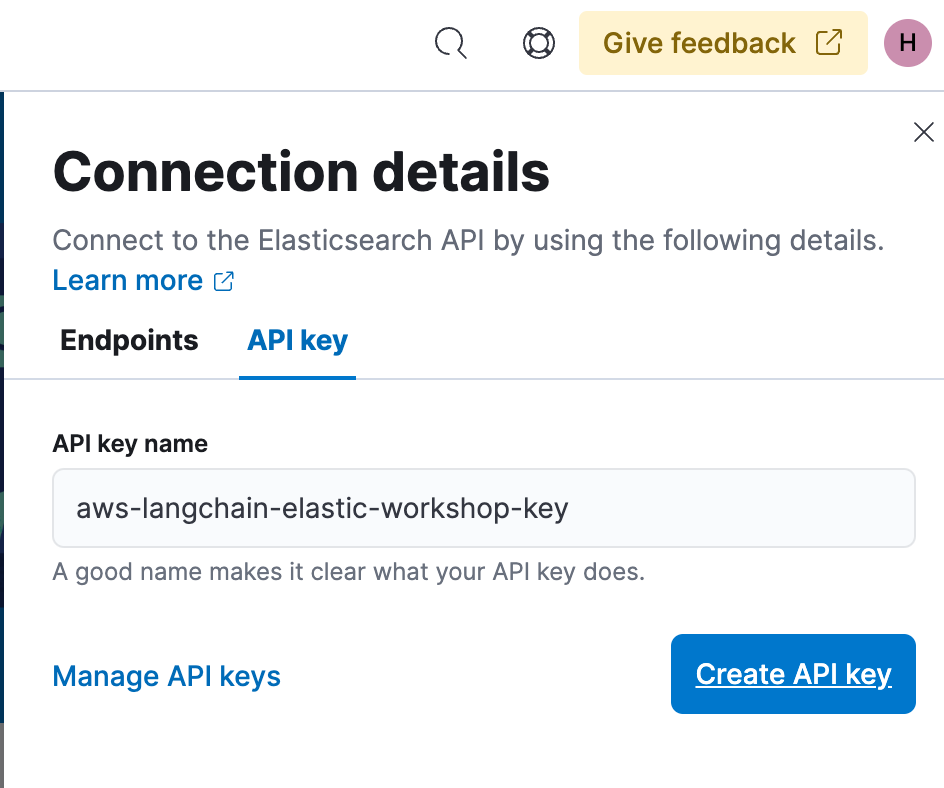

#### Python 3.10

⚠  For this lab we need to run the notebook based on a Python 3.10 runtime. ⚠


## Installation

To run this notebook you would need to install dependencies - boto3, botocore, elasticsearch and langchain.

In [ ]:
%pip install --upgrade pip
%pip install boto3 --force-reinstall --quiet
%pip install botocore --force-reinstall --quiet
%pip install langchain --force-reinstall --quiet
%pip install langchain_community --force-reinstall --quiet
%pip install langchain-elasticsearch --force-reinstall --quiet
%pip install elasticsearch --force-reinstall --quiet
%pip install unstructured==0.7.12 --force-reinstall --quiet

## Kernel Restart

Restart the kernel with the updated packages that are installed through the dependencies above

In [ ]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Setup 

Import the necessary libraries

In [ ]:
import json
import os
import sys
import boto3
import botocore
import nltk
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models.bedrock import BedrockChat
from langchain.embeddings import BedrockEmbeddings
from botocore.client import Config
from langchain_community.retrievers import AmazonKnowledgeBasesRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_elasticsearch import ElasticsearchStore
from elasticsearch import Elasticsearch
from langchain.schema.runnable import RunnablePassthrough
from langchain.chains import RetrievalQA
from getpass import getpass
from langchain.prompts import PromptTemplate
from langchain.document_loaders import DirectoryLoader
from pathlib import Path

## Initialization

Initiate Bedrock Runtime and BedrockChat

In [ ]:
bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 0})
bedrock_client = boto3.client('bedrock-runtime')

modelId = 'anthropic.claude-3-sonnet-20240229-v1:0' # change this to use a different version from the model provider
embeddingmodelId = 'amazon.titan-embed-text-v1' # change this to use a different embedding model

llm = BedrockChat(model_id=modelId, client=bedrock_client)
embeddings = BedrockEmbeddings(model_id=embeddingmodelId,client=bedrock_client)

## Read files from directory

Load all PDF files which are present in the directory

In [ ]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
TMP_DIR = os.path.join(os.path.dirname(os.path.realpath('__file__')), 'media')
loader = DirectoryLoader(TMP_DIR, glob='**/*.pdf')
documents = loader.load()

## Split Documents

Chunk documents into passages in order to improve the retrieval specificity and to ensure that we can provide multiple passages within the context window of the final question answering prompt.

Here we are chunking documents into 1000 token passages with an overlap of 0 tokens.

Here we are using Recursive Character Text splitter but Langchain offers more advanced splitters to reduce the chance of context being lost.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
        separators=['\n\n', '\n', '.', ','],
        chunk_size=1000,
        chunk_overlap=0
        )
texts = text_splitter.split_documents(documents)

## Connect to Elasticsearch

We'll use the Cloud ID to identify our deployment. To find the Cloud ID for your Elastic serverless project, go to [Projects](https://cloud.elastic.co/projects) and select your project.

We will use ElasticsearchStore to connect to Elasticsearch vector database. This would help create and index data easily. 

In [ ]:
cloud_id = getpass("Elastic deployment Cloud ID: ")
cloud_api_key = getpass("Elastic deployment API Key: ")
index_name= "new-index-1"

vector_store = ElasticsearchStore(
        es_cloud_id=cloud_id,  
        index_name= index_name, 
        embedding=embeddings,
        es_api_key=cloud_api_key)

## Index data into Elasticsearch and initialize retriever

Next, we will index data to elasticsearch using ElasticsearchStore.from_documents. We will use Cloud ID, API Key and Index name values set in the Create cloud deployment step. We will set embedding to BedrockEmbeddings to embed the texts.

In [ ]:
vectordb = vector_store.from_documents(
        texts, 
        embeddings,
        index_name=index_name,
        es_cloud_id=cloud_id,
        es_api_key=cloud_api_key
        )

retriever = vectordb.as_retriever()

## Model Invocation and Response Generation using RetrievalQA chain

Now that we have the passages stored in Elasticsearch and LLM is initialized, we can now ask a question to get the relevant passages.

In [ ]:
query = "What is an important first step for machine learning metamodeling?"


machinelearning_advisor_template = """
    Human: You will be acting as a Machine Learning advisor on complex Mechanical systems named Poly created by the company Polymath. 
    Your goal is to give advice related to Application of Machine Learning on Mechanical Systems to users. You will be replying to users 
    who are asking questions on Application of Machine Learning in Mechanical Systems 
    site and who will be confused if you don't respond in the character of Poly.
    
    You should maintain a friendly customer service tone.

    Here is the document you should reference when answering the user: <context>{context}</context>

    Here are some important rules for the interaction:
    - Always stay in character, as Poly, a Machine Learning advisor on complex Mechanical systems
    - If you are unsure how to respond, say “Sorry, I didn’t understand that. Could you repeat the question?”
    - If someone asks something irrelevant, say, “Sorry, I am Poly and I give career advice. Do you have a question related to Application of Machine Learning in Mechanical Systems today I can help you with?”

    Here is an example of how to respond in a standard interaction:

    <example>
    User: Hi, how were you created and what do you do?
    Poly: Hello! My name is Poly, and I was created by Polymath  to give advice on Application of Machine Learning in Mechanical Systems. 
        What can I help you with today?
    User: Hi, how can I use Decision Trees?
    Poly: The method for using decision trees described in the given context is to first rank all
        all the rules within the decision tree to find the most meaningful and reliable design subspaces.
        Then, determine how many significant rules exist within the dataset to present the engineer
        with the most reliable and important knowledge. Finally, use the resulting rules from the decision tree
        to make predictions or decisions based on the given target variable.
        User: Hi, What is Machine Learning?
    Poly: Machine learning is a tool that allows predictions about future behavior to be drawn from existing
        data sets. It is used in everything from spam filters to self-driving cars. While the field has been
        around for decades, it has flourished over the last several years as computing power has increased
        and user-friendly toolkits have been developed in a variety of programming languages. We do not
        go into detail on machine learning theory and practice in this paper, but we do introduce the
        concepts necessary for understanding our implementation of it.
    </example>

    Here is the user’s question: <question> {question} </question>

    How do you respond to the user’s question?
    Think about your answer first before you respond. Put your response in <response></response> tags.
    Assistant: <response>"""

prompt = PromptTemplate(template=machinelearning_advisor_template, input_variables=["context","question"])
qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff",retriever=retriever, return_source_documents=True, chain_type_kwargs={"prompt": prompt})
response = qa_chain.invoke(query)
print(response["result"])

## Delete Elasticsearch Index

Delete the Elasticsearch index

In [ ]:
es = Elasticsearch(cloud_id=cloud_id, api_key=cloud_api_key)
es.options(ignore_status=[400,404]).indices.delete(index=index_name)

## Conclusion
You have now experimented with `langchain` SDK to get an exposure to RAG Application building using Elastic, Anthropic Claude 3 and Amazon Bedrock API. Using langchain you have asked questions on your domain specicific documents.

### Take aways
- Adapt this notebook to experiment with different Claude 3 models available through Amazon Bedrock. 
- Change the prompts to your specific usecase and evaluate the output of different models.
- Play with the token length to understand the latency and responsiveness of the service.
- Apply different prompt engineering principles to get better outputs.

## Thank You